# Bidirectional LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           1344      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 76,103
Trainable params: 76,103
Non-trainable params: 0
____________________________________________________

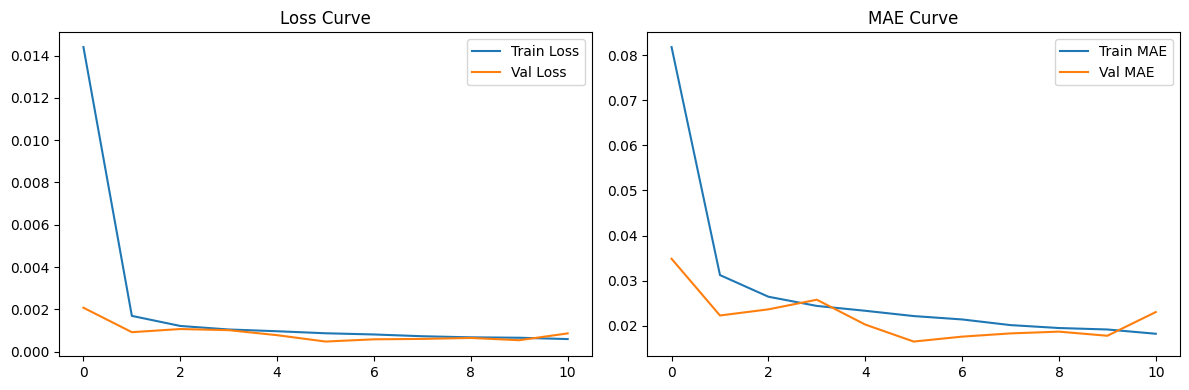

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })

    return df
df = read_rename('proteinas_20000_enriquecido.csv')

all_chars = set("".join(df['sequence'].values))
char_to_index = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
vocab_size = len(char_to_index) + 1
encoded_sequences = [[char_to_index[char] for char in seq] for seq in df['sequence']]
max_length = max(len(seq) for seq in encoded_sequences)
X_all = pad_sequences(encoded_sequences, maxlen=max_length, padding='post')
y_all = df[['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge', 'polar_ratio','nonpolar_ratio','sequence_length']].values
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(7)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.build(input_shape=(None, max_length))  
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_scaled,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

print(pd.DataFrame(y_pred[:5], columns=['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']))
from sklearn.metrics import r2_score

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
target_names = ['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']

print("\nAkurasi (R² Score) per Target Variabel:")
for name, r2 in zip(target_names, r2_scores):
    print(f"{name}: {r2:.4f}")

# Jika ingin menampilkan rata-rata R² Score:
mean_r2 = np.mean(r2_scores)
print(f"\nRata-rata R² Score (Akurasi keseluruhan): {mean_r2:.4f}")


# 12. Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("MAE Curve")

plt.tight_layout()
plt.show()



In [2]:
from sklearn.metrics import mean_squared_error

# 13. Hitung RMSE untuk tiap target variabel
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
target_names = ['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']

print("\nRMSE per Target Variabel:")
for name, rmse in zip(target_names, rmse_scores):
    print(f"{name}: {rmse:.4f}")

# Jika ingin menampilkan rata-rata RMSE keseluruhan
mean_rmse = np.mean(rmse_scores)
print(f"\nRata-rata RMSE: {mean_rmse:.4f}")



RMSE per Target Variabel:
mw: 608.1881
pI: 0.2314
hydro: 0.0054
charge: 2.0205
polar: 0.0056
nonpolar: 0.0081
seq_len: 4.2729

Rata-rata RMSE: 87.8188


In [ ]:
import pickle
import json
import os
os.makedirs('model', exist_ok=True)

model.save('model/lstm_model.keras')

with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model/char_to_index.pkl', 'wb') as f:
    pickle.dump(char_to_index, f)

with open('model/config.json', 'w') as f:
    json.dump({"max_length": max_length}, f)

print("✅ Model, scaler, char_to_index, dan config berhasil disimpan.")


✅ Model, scaler, char_to_index, dan config berhasil disimpan.


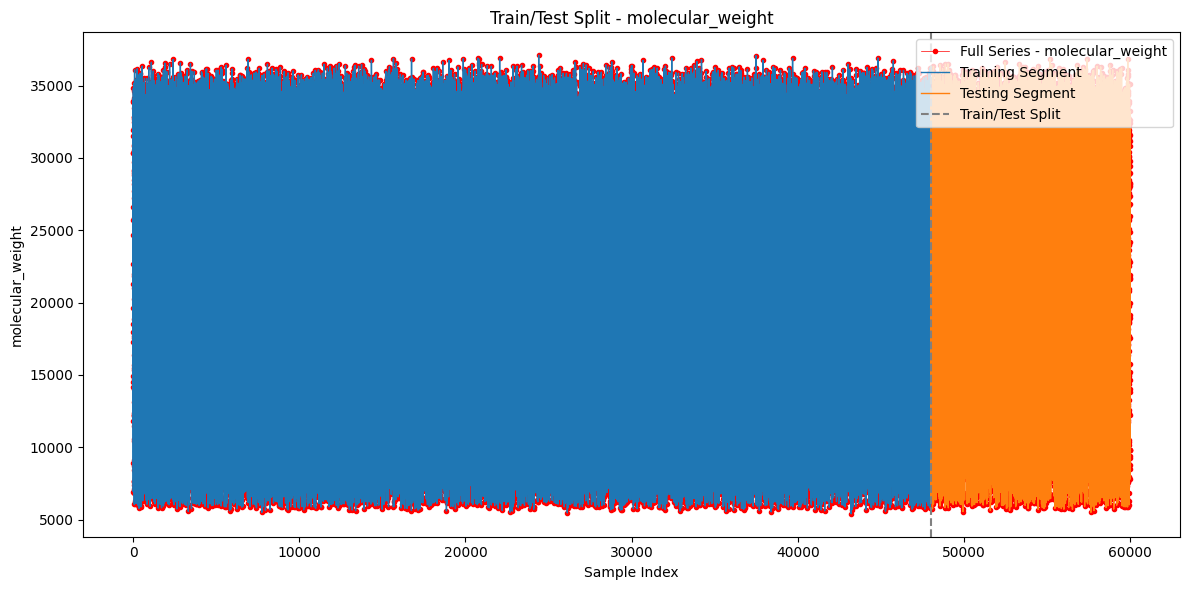

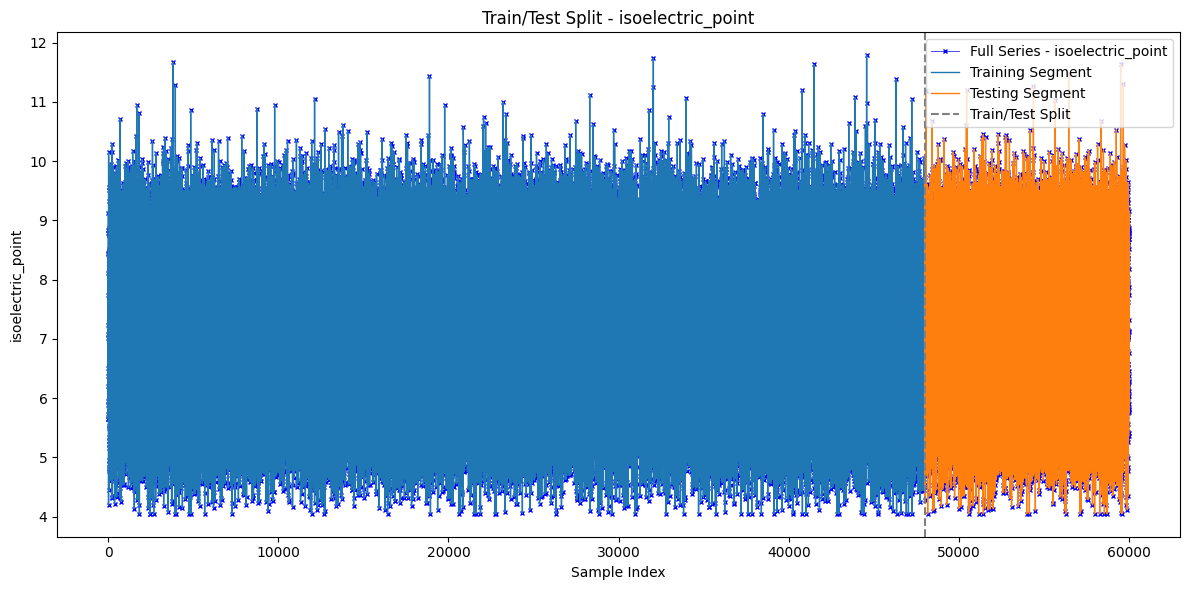

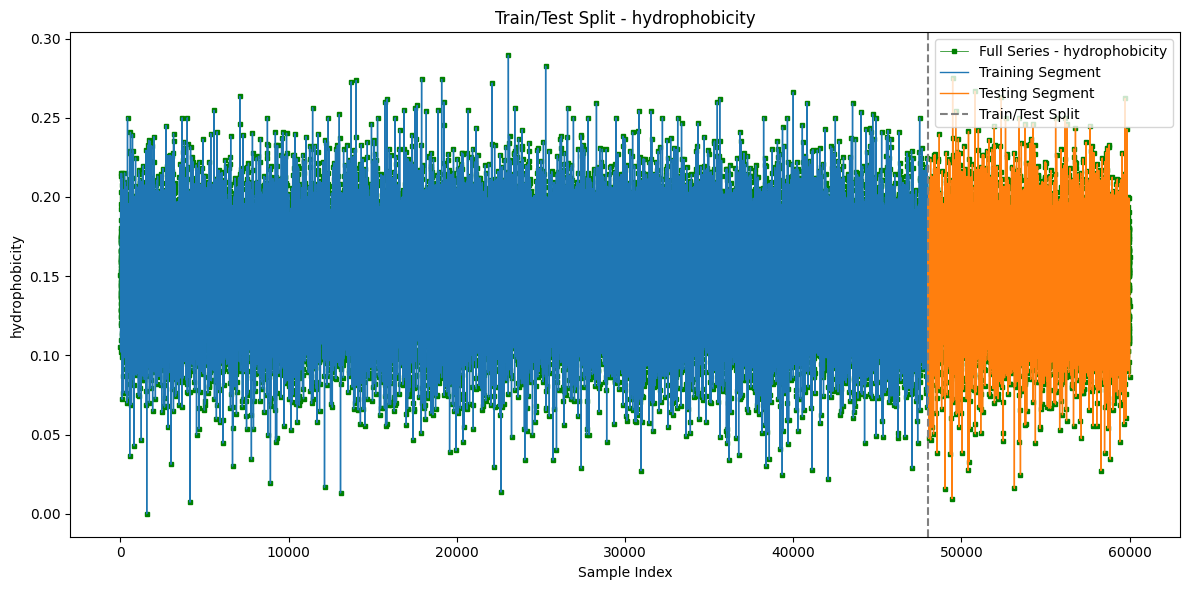

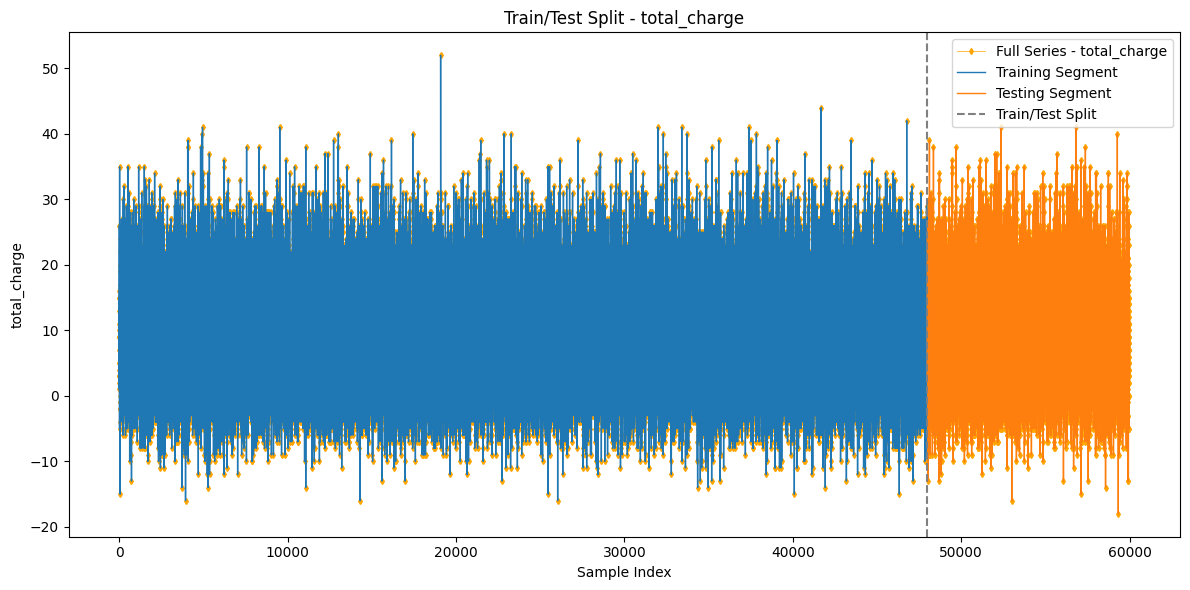

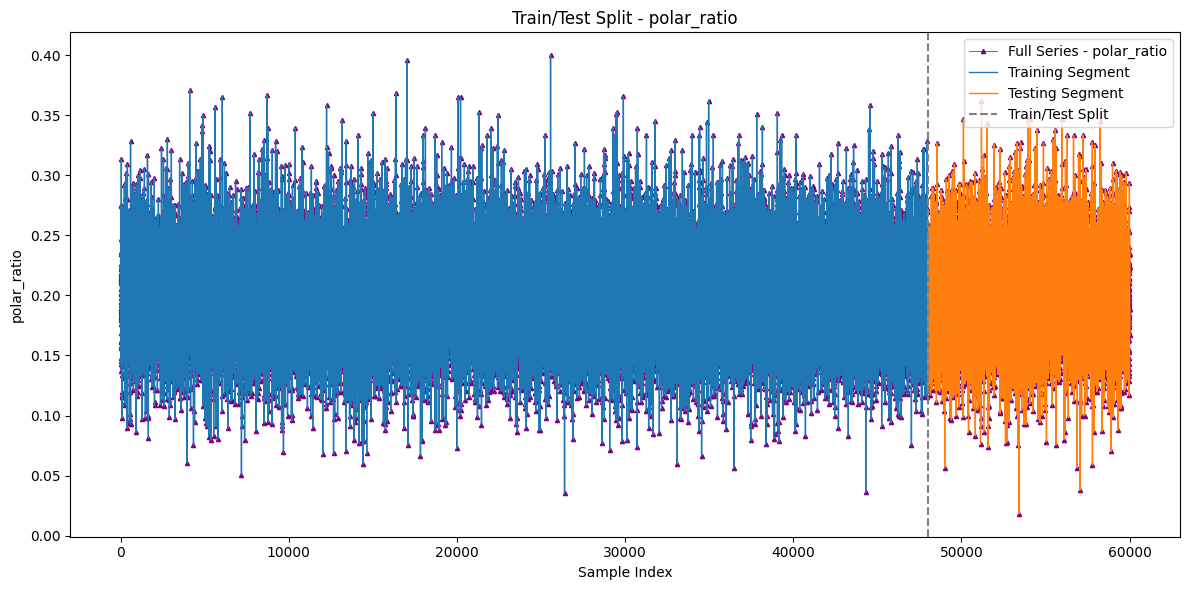

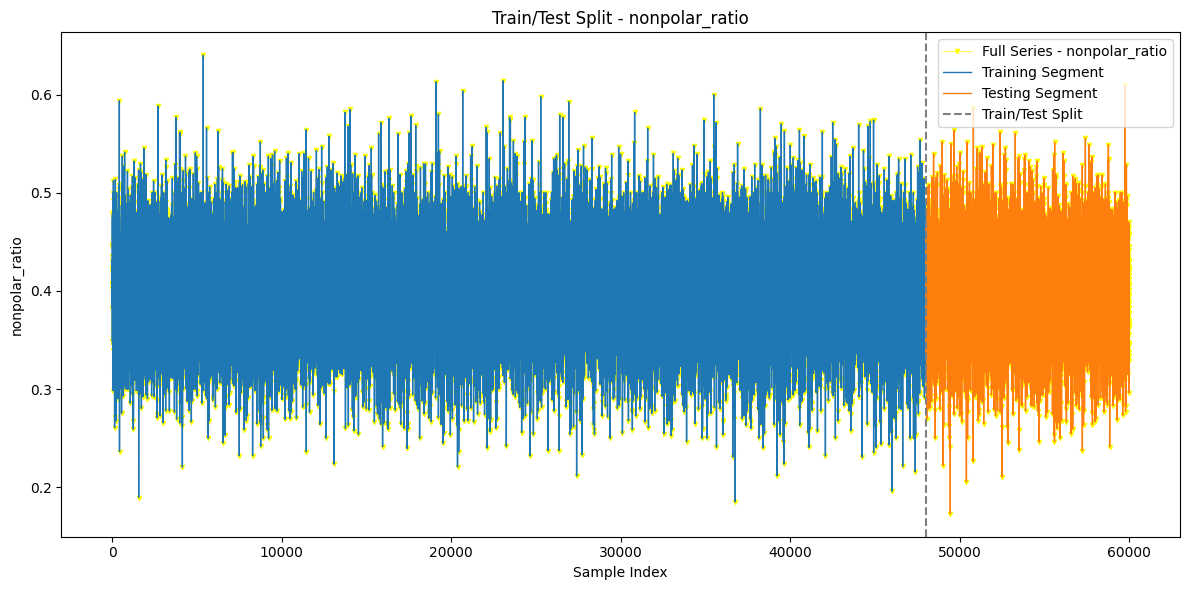

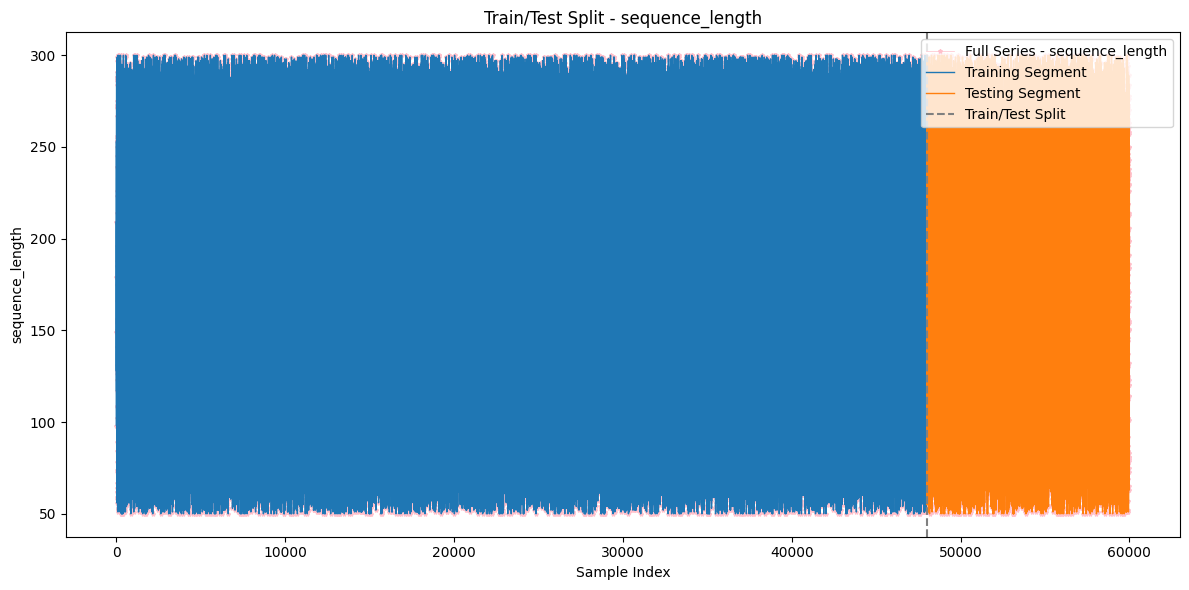

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

time = np.arange(len(y))
split_idx = int(0.8 * len(y))  
window_size = 0

train_end_time = split_idx + window_size
test_start_time = train_end_time

feature_names = ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge',
                 'polar_ratio','nonpolar_ratio','sequence_length']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
markers = ['o', 'x', 's', 'd', '^', 'v', '*']

def plot_feature(time, series, feature_name, color, marker):
    plt.figure(figsize=(12, 6))
    plt.plot(time, series, linestyle='-', linewidth=0.5, marker=marker, markersize=3,
             color=color, label=f'Full Series - {feature_name}')
    
    plt.plot(time[window_size:train_end_time],
             series[window_size:train_end_time], color='C0', lw=1,
             label='Training Segment')
    
    plt.plot(time[test_start_time:], series[test_start_time:], color='C1', lw=1,
             label='Testing Segment')
    
    plt.axvline(x=train_end_time, color='gray', linestyle='--', label='Train/Test Split')
    plt.title(f"Train/Test Split - {feature_name}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{feature_name}")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

for i, (name, color, marker) in enumerate(zip(feature_names, colors, markers)):
    plot_feature(time, y_full[:, i], name, color, marker)


# K-Means Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })

    return df
df1= read_rename('proteinas_20000_enriquecido.csv')

In [2]:
df1["class"].value_counts()

class
Outras        12216
Estrutural    11991
Transporte    11989
Enzima        11954
Receptora     11850
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder
train=df1
label_encoder = LabelEncoder()
train['class']=label_encoder.fit_transform(train['class'])

In [5]:
from sklearn.model_selection import train_test_split

X_train = train.drop(columns=['class'])

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   protein_id         60000 non-null  object 
 1   sequence           60000 non-null  object 
 2   molecular_weight   60000 non-null  float64
 3   isoelectric_point  60000 non-null  float64
 4   hydrophobicity     60000 non-null  float64
 5   total_charge       60000 non-null  int64  
 6   polar_ratio        60000 non-null  float64
 7   nonpolar_ratio     60000 non-null  float64
 8   sequence_length    60000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 4.1+ MB


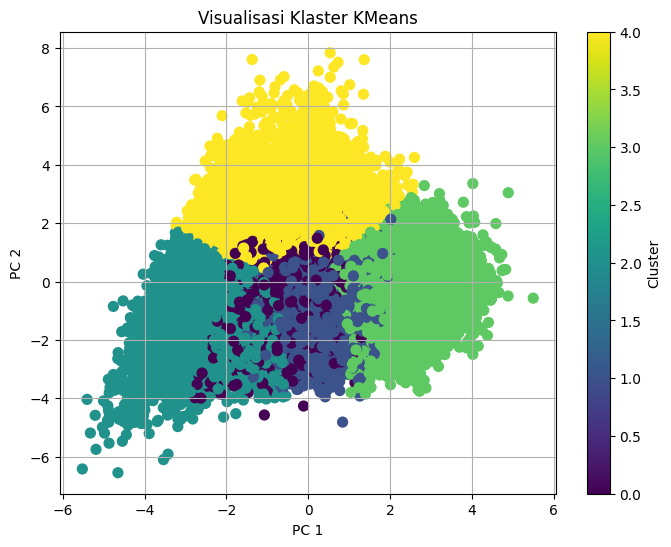

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
features = ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 
            'total_charge', 'polar_ratio', 'nonpolar_ratio', 'sequence_length']
X = X_train[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

X_train['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title("Visualisasi Klaster KMeans")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics.pairwise import euclidean_distances
similar_df = X_train[X_train['cluster'] == user_cluster].copy()
similar_df['distance'] = euclidean_distances(
    scaler.transform(similar_df[features]), user_vec_scaled
)
closest_match = similar_df.sort_values('distance').iloc[0]


In [15]:
print("Sequence paling mirip dengan input user:")
print("Sequence:", closest_match['sequence'])
print("Jarak fisiokimia:", closest_match['distance'])


Sequence paling mirip dengan input user:
Sequence: MQQTMSNTGGQDVNHSKFISNMIMSPYQFRHNYIMNRQTNRCCTNHHPWW
Jarak fisiokimia: 7.573102065979371


In [ ]:
import joblib
X_train.to_csv("train_data.csv", index=False)  
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans.pkl")

['kmeans.pkl']

# Analisis CNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 64)           1344      
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           20544     
                                                                 
 conv1d_1 (Conv1D)           (None, 294, 128)          24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 292, 256)          98560     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

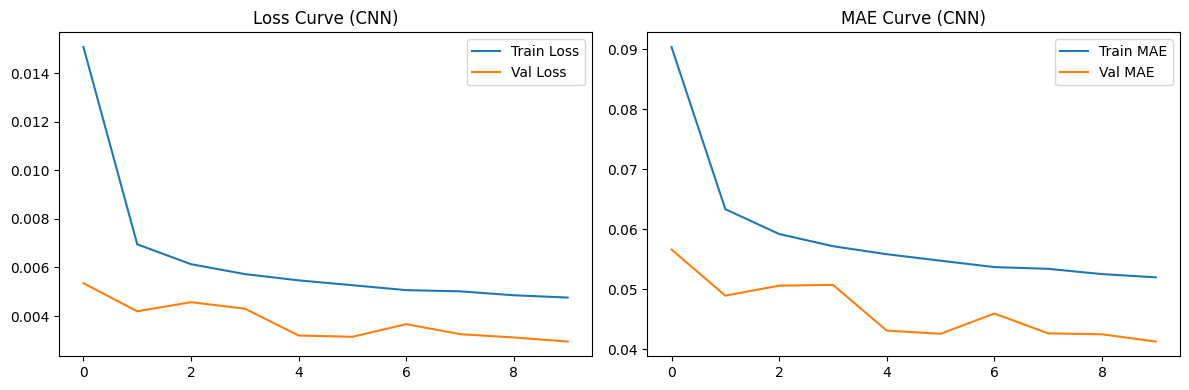

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })
    return df

df = read_rename('proteinas_20000_enriquecido.csv')

all_chars = set("".join(df['sequence'].values))
char_to_index = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
vocab_size = len(char_to_index) + 1

encoded_sequences = [[char_to_index[char] for char in seq] for seq in df['sequence']]
max_length = max(len(seq) for seq in encoded_sequences)
X_all = pad_sequences(encoded_sequences, maxlen=max_length, padding='post')

y_all = df[['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge', 'polar_ratio', 'nonpolar_ratio', 'sequence_length']].values

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=256, kernel_size=3, activation='relu'),

    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(7)  
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_scaled,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

print(pd.DataFrame(y_pred[:5], columns=['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve (CNN)")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("MAE Curve (CNN)")

plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import r2_score

# 13. Hitung dan tampilkan R² Score untuk tiap target variabel
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
target_names = ['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']

print("\nAkurasi (R² Score) per Target Variabel:")
for name, r2 in zip(target_names, r2_scores):
    print(f"{name}: {r2:.4f}")

# Jika ingin menampilkan rata-rata R² Score:
mean_r2 = np.mean(r2_scores)
print(f"\nRata-rata R² Score (Akurasi keseluruhan): {mean_r2:.4f}")



Akurasi (R² Score) per Target Variabel:
mw: 0.9539
pI: 0.8288
hydro: 0.8157
charge: 0.8361
polar: 0.7482
nonpolar: 0.7918
seq_len: 0.9540

Rata-rata R² Score (Akurasi keseluruhan): 0.8469


In [5]:
from sklearn.metrics import mean_squared_error

# 13. Hitung RMSE untuk tiap target variabel
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
target_names = ['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']

print("\nRMSE per Target Variabel:")
for name, rmse in zip(target_names, rmse_scores):
    print(f"{name}: {rmse:.4f}")

# Jika ingin menampilkan rata-rata RMSE keseluruhan
mean_rmse = np.mean(rmse_scores)
print(f"\nRata-rata RMSE: {mean_rmse:.4f}")



RMSE per Target Variabel:
mw: 1835.6575
pI: 0.5967
hydro: 0.0116
charge: 2.9927
polar: 0.0169
nonpolar: 0.0191
seq_len: 15.4091

Rata-rata RMSE: 264.9576
